# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


import warnings
warnings.filterwarnings('ignore')

In [3]:
print(df0.info())
print(df1.info())
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

In [4]:
print(df0.head())
print(df1.head())
print(df2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [5]:
for df in [df0, df1, df2]:
    print('Уникальных id: ', len(df['id'].unique()))
    print('Количество NaN:\n', df1.isna().sum())

Уникальных id:  99990
Количество NaN:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Уникальных id:  99996
Количество NaN:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Уникальных id:  99996
Количество NaN:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%       

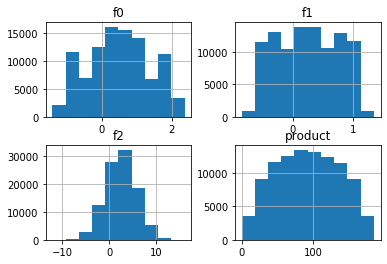

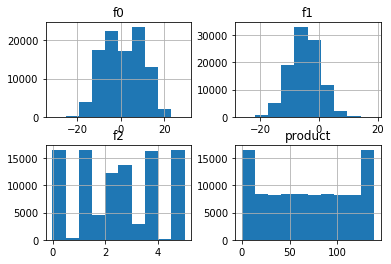

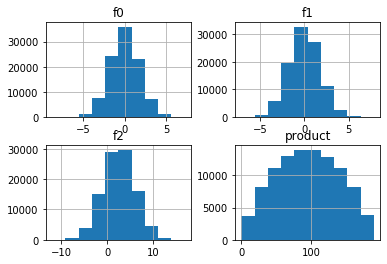

In [5]:
for df in [df0, df1, df2]:
    print(df.describe())
    df.hist()


Имеем три датафрейма по 100 тысяч объектов в каждом и 4 признака, один из которых ('product') будет принят в качестве целевого.
Пропусков и повторов в сколько-нибудь значимых количествах не обнаружено. Распределение всех признаков, за исключением 'f2' и 'product' в датафрейме под номером 1, напоминает нормальное. 

In [6]:
# 

target0 = df0['product']
features0 = df0.drop(['product', 'id'], axis=1)
target1 = df1['product']
features1 = df1.drop(['product', 'id'], axis=1)
target2 = df2['product']
features2 = df2.drop(['product', 'id'], axis=1)

# Разделим выборки на обучающую и валидационную для каждого из регионов:

features0_train, features0_valid, target0_train, target0_valid = train_test_split(features0, target0, test_size = 0.25, random_state = 123)
features1_train, features1_valid, target1_train, target1_valid = train_test_split(features1, target1, test_size = 0.25, random_state = 123)
features2_train, features2_valid, target2_train, target2_valid = train_test_split(features2, target2, test_size = 0.25, random_state = 123)

print(features0_valid.head())

print(target0_valid.head())

             f0        f1        f2
42083  0.331011 -0.288668  6.134432
71825 -0.027196  0.189525  0.160777
99535 -0.982324  0.286965 -2.163846
47879  0.686155  0.797873  2.689418
36734  0.603928  0.605621  5.852418
42083    145.825972
71825    134.020212
99535     88.905826
47879     19.508226
36734    108.713468
Name: product, dtype: float64


Разделим признаки на целевой и прочие. Разделим получившиеся выборки на обучающую и валидационную в соотношении 3:1 в соответствии с заданием. Выведем две из получившихся выборок на экран, чтобы проверить, как прошло разделение.

In [7]:
# Проведем масштабирование признаков f0.. f2

to_be_scaled = ['f0', 'f1', 'f2']

scaler = StandardScaler()
print('features0_train до масштабирования:\n', features0_train.head(3))
# display('features1_train до масштабирования:\n', features1_train.head(3))
# display('features2_train до масштабирования:\n', features2_train.head(3))

for features_train, features_valid in zip([features0_train, features1_train, features2_train], 
                                          [features0_valid, features1_valid, features2_valid]):
    
    
    scaler.fit(features_train[to_be_scaled])
    features_train[to_be_scaled]= scaler.transform(features_train[to_be_scaled])
    features_valid[to_be_scaled]= scaler.transform(features_valid[to_be_scaled])


print('features0_train после масштабирования:\n', features0_train.head(3))
# display('features1_train после масштабирования:\n', features1_train.head(3))
# display('features2_train после масштабирования:\n', features2_train.head(3))

features0_train до масштабирования:
              f0        f1        f2
31450  0.304856 -0.439498  6.551519
42809  0.585391  0.964728  0.463974
52419  0.339017  0.921952  2.210054
features0_train после масштабирования:
              f0        f1        f2
31450 -0.222207 -1.370730  1.249553
42809  0.099624  1.415305 -0.627968
52419 -0.183017  1.330436 -0.089442


Поскольку принятая в здесь качестве используемой модели линейная регрессия чувствительна к различиям в абсолютных величинах признаков, проведем их масштабирование с использованием класса StandardScaler. Постоянно повторяющиеся действия обернем в цикл, чтобы сократить запись и повысить читаемость кода. Выведем одну из масштабируемых выборок на экран до и после предпринятых действий, чтобы оценить результат.

# 2. Обучение и проверка модели

In [8]:
model = LinearRegression()
for features_train, target_train in zip([features0_train, features1_train, features2_train], 
                                        [target0_train, target1_train, target2_train]):
    lir_params = {'fit_intercept': [True, False],
                  'normalize': [True, False]

                  }

    lir_cv = GridSearchCV(model, lir_params)
    lir_cv.fit(features_train, target_train)
    print(lir_cv.best_params_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
{'copy_X': True, 'fit_intercept': True, 'normalize': True}


Проведём подбор оптимальных гиперпараметров с использованием метода GridSearchCV. 

In [9]:
# Обучим модель линейной регрессии отдельно для каждого региона:
model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)

# Обернём повторяющийся блок кода в функцию и вызовем её поочередно для каждого региона:
def linear_predict(features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    prediction = pd.Series(prediction, index=target_valid.index)
    print('Прогнозные значения (5 первых):\n', prediction.head())
    print('Реальные значения (5 первых):\n', target_valid.head())
    
    print('Средние предсказанные резервы: ', prediction.mean())
    print('Средние реальные резервы: ', target_valid.mean())
    print('RMSE: ', mean_squared_error(target_valid, prediction)**0.5)
    prediction.hist()
    
    pl.suptitle("Распределение прогнозируемых резервов")
    
    return prediction

Прогнозные значения (5 первых):
 42083    123.284256
71825     75.838240
99535     55.526760
47879     86.673045
36734    109.909327
dtype: float64
Реальные значения (5 первых):
 42083    145.825972
71825    134.020212
99535     88.905826
47879     19.508226
36734    108.713468
Name: product, dtype: float64
Средние предсказанные резервы:  92.54936189116309
Средние реальные резервы:  92.85062391123445
RMSE:  37.64786282376177


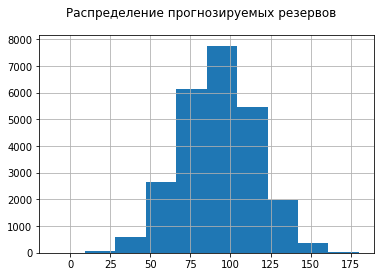

In [10]:
prediction0 = linear_predict(features0_train, target0_train, features0_valid, target0_valid)   


Прогнозные значения (5 первых):
 42083     56.056314
71825     81.589811
99535     54.461926
47879    108.660979
36734     54.479416
dtype: float64
Реальные значения (5 первых):
 42083     57.085625
71825     80.859783
99535     53.906522
47879    107.813044
36734     53.906522
Name: product, dtype: float64
Средние предсказанные резервы:  69.28001860653976
Средние реальные резервы:  69.27371236077902
RMSE:  0.8954139804944306


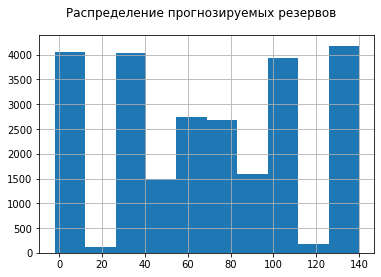

In [11]:
prediction1 = linear_predict(features1_train, target1_train, features1_valid, target1_valid)   


Прогнозные значения (5 первых):
 42083     94.075161
71825    122.604414
99535     80.055039
47879    100.175906
36734     89.804044
dtype: float64
Реальные значения (5 первых):
 42083    147.451978
71825    128.711794
99535    106.628185
47879    128.787131
36734    159.328488
Name: product, dtype: float64
Средние предсказанные резервы:  95.09859933591373
Средние реальные резервы:  94.87348818660215
RMSE:  40.12803006598514


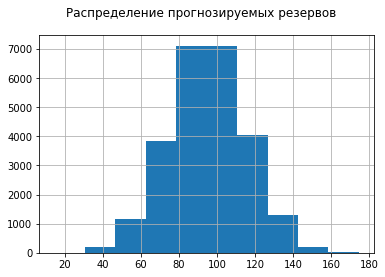

In [12]:
prediction2 = linear_predict(features2_train, target2_train, features2_valid, target2_valid)   

Создадим функцию, принимающую требуемые выборки, обучающую на них модель и строящую необходимый прогноз с вычислением выбранной метрики качества (RMSE) и отображением распределения прогнозируемых резервов на гистограмме. Трижды вызовем эту функцию - отдельно для каждого исследуемого региона и оценим получившиеся результаты.

Значения средних реальных и средних предсказанных резервов лишь очень незначительно отличаются друг от друга. Разница же между отдельными значениями в предсказании и ответах иногда весьма значительна. 
Наилучшая метрика качества (корень среднеквадратичной ошибки) получена моделью для региона №1.  

In [13]:
BUDGET_PRO_WELL = 10000000000/200
BUDGET_PRO_WELL

50000000.0

In [14]:
MINIMAL_RESERVES = BUDGET_PRO_WELL/450000
MINIMAL_RESERVES

111.11111111111111

Если предположить, что затраты на разработку и обслуживание каждой скважины распределены равномерно, то из условия задачи  следует, что на одну скважину придется 50 миллионов рублей бюджета, то есть запасы нефти в ней должны были бы быть не меньше 111 тыс. баррелей, что ниже средних запасов в каждом из исследуемых регионов (от 69,3 до 94,9 тыс. баррелей).

Однако, поскольку цена разработки от скважины к скважине может варьироваться, а так же в бюджет с необходимостью будут включены затраты на разведку и общие для ряда скважин инфраструктурные издержки, одного этого значения недостаточно, чтобы рекомендовать регион с наибольшей прибылью и наименьшими рисками убытков. Требуется рассмотреть задачу в комплексе, т.е. взять 500 случайно разведанных скважин, отобрать из них 200 с максимальными предсказанными запасами и оценить прибыль и ее распределение.

# 3. Подготовка к расчёту прибыли

In [15]:
# Сохраним ключевые для расчёта себестоимости значения в отдельных переменных:
PROFIT_PRO_BARREL = 450
EXTRACTION_COST = 10000000000


In [16]:

def profit(real_reserves, predicted_reserves, selected_sites):

    predicted_reserves_sorted = predicted_reserves.sort_values(ascending=False)
    selected = real_reserves[predicted_reserves_sorted.index][:selected_sites]
    return PROFIT_PRO_BARREL*1000 * selected.sum() - EXTRACTION_COST

Напишем функцию, вычисляющую прибыль от эксплуатации 200 (при selected_sites=200) скважин с наибольшими резервами из поданных на вход данных о реальных и прогнозируемых запасах на 500 скважинах. 

In [17]:


def bootstrap(target_valid, prediction, subsamples_number, selected_sites, region_name):
    state = np.random.RandomState(123)
    profit_values = []
    

    for i in range(subsamples_number):
        target_subsample = target_valid.sample(n=500, replace=True, random_state=state)
        prediction_subsample = prediction[target_subsample.index]
        profit_values.append(profit(target_subsample, prediction_subsample, selected_sites))
        
    profit_values = pd.Series(profit_values)
    lower = profit_values.quantile(0.025)
    upper = profit_values.quantile(0.975)
    print('Нижняя граница 95%-интервала:{:.2} млрд. руб'.format(lower/1000000000))
    print('Верхняя граница 95%-интервала:{:.2}, млрд. руб'.format(upper/1000000000))
    print('Средняя прибыль по региону {}: {:.2}'.format(region_name, profit_values.mean()/1000000000), 'млрд. руб')
    print('Риск убытка по региону {}: {}%'.format(region_name, 100*profit_values[profit_values<0].count()/profit_values.count()))

    plt.hist(profit_values, density=1, bins=30, facecolor='g', alpha=0.75)
    ax=plt.axvline(x=lower, color='r', linestyle='--', label='Границы 95%-\nинтервала')
    plt.axvline(x=upper, color='r', linestyle='-.')
    ax1=plt.axvline(x=profit_values.mean(), color='b', linestyle='--', label='Средняя прибыль')
    pl.suptitle("Распределение прибыли в регионе {}".format(region_name))    
    plt.legend(handles=[ax, ax1])
    plt.show()

    return profit_values, profit_values.mean(), 100*profit_values[profit_values<0].count()/profit_values.count()


Функция "bootstrap" выбирает из списка с ответами 500 случайных объектов (с возвращением), и, вместе с 500 соответствующими им (по индексу) значениями предсказаний, передает их на вход функции "profit", записывая получившийся ответ в лист. Процедура повторяется 1000 раз (при subsamples_number=1000) - составленный таким образом вектор позволит построить гистограмму распределения прибыли.    

# 4. Расчёт прибыли и рисков 

Нижняя граница 95%-интервала:-0.052 млрд. руб
Верхняя граница 95%-интервала:1.0, млрд. руб
Средняя прибыль по региону 0: 0.5 млрд. руб
Риск убытка по региону 0: 4.0%


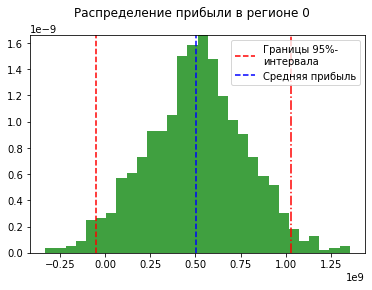

In [18]:
profit0_values, profit0_mean, loss0_risk = bootstrap(target0_valid, prediction0, subsamples_number=1000, selected_sites=200, region_name='0')


Нижняя граница 95%-интервала:0.1 млрд. руб
Верхняя граница 95%-интервала:0.96, млрд. руб
Средняя прибыль по региону 1: 0.54 млрд. руб
Риск убытка по региону 1: 0.5%


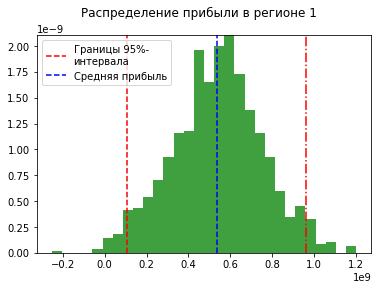

In [19]:
profit1_values, profit1_mean, loss1_risk = bootstrap(target1_valid, prediction1, subsamples_number=1000, selected_sites=200, region_name='1')


Нижняя граница 95%-интервала:-0.22 млрд. руб
Верхняя граница 95%-интервала:0.91, млрд. руб
Средняя прибыль по региону 2: 0.36 млрд. руб
Риск убытка по региону 2: 9.5%


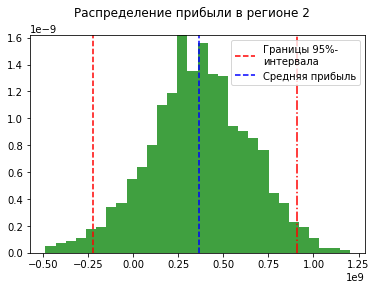

In [20]:
profit2_values, profit2_mean, loss2_risk = bootstrap(target2_valid, prediction2, subsamples_number=1000, selected_sites=200, region_name='2')


Применим ранее описанные функции к данным по каждому из трех интересующих нас регионов. Риск убытка варьируется от 9.5 до 0.5%, средняя прибыль - от 0.36 млрд. до 0.54 млрд. рублей. Единственным удовлетворяющим критерию минимизации риска убытков (не более 2.5%) регионом является регион №1. 

# Вывод

В ходе выполнения проекта были проанализированы данные о нефтяных скважинах в трёх регионах. Данные были проверены на предмет пропусков и артефактов, а так же подготовлены к использованию модели линейной регрессии (проведено масштабирование). Были обученымодели, прогнозирующие запасы нефти с учетом особенностей каждого региона, а так же проведена оценка качества этих моделей с исользованием метрики RMSE. Поскольку более простые методы (оценка необходимых средних запасов) не позволяли с делать сколько-нибудь надёжных выводов, для построения распределения прогнозируемой прибыли и обоснованного выбора региона, где добыча принесет наибольшую прибыль, была использована техника Bootstrap. Выводы были подкреплены графическим представлением в виде гистаграмм.



По итогу исследования необходимо было оставить лишь регионы с риском убытков ниже 2.5% - в нашем случае этому критерию удовлетворяет лишь регион №1. На этот же регион приходится и максимальная средняя прогнозируемая прибыль - 0.538 млрд. рублей. Таким образом, мы имеем все основания выбрать регион №1 в качестве рекомендованного к разработке.